In [7]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf


random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.optimizers import SGD

%matplotlib inline

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from sklearn import preprocessing
from tensorflow.keras.layers import LSTM

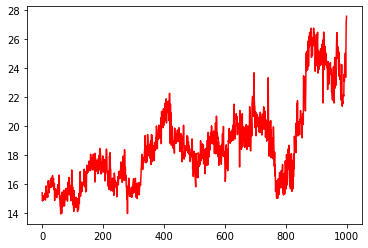

In [10]:
import pandas as pd

csv_file_path = 'close.csv'

df = pd.read_csv(csv_file_path, header=None)

close = df[0].tolist()
logclose = np.log(close).tolist()


plt.plot(close , color = 'r')
plt.show()

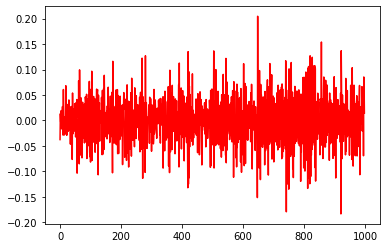

In [ ]:
from math import floor

size = len(close) - 100
close_train, close_test = close[0:size], close[size:len(close)]
logclose_train, logclose_test = logclose[0:size], logclose[size:len(logclose)]

logreturns = np.diff(logclose).tolist()
logreturns_train, logreturns_test = logreturns[0:size-1], logreturns[size-1:len(logreturns)]

series = logreturns
train = logreturns_train
test = logreturns_test

plt.plot(series , color = 'r')
plt.show()

train = np.array(train).reshape(-1,1)


Epoch 1/2000
51/51 [==============================] - 1s 4ms/step - loss: 0.9797 - val_loss: 1.5218
Epoch 2/2000
51/51 [==============================] - 0s 2ms/step - loss: 0.9285 - val_loss: 1.4867
Epoch 3/2000
51/51 [==============================] - 0s 2ms/step - loss: 0.8978 - val_loss: 1.4056
Epoch 4/2000
51/51 [==============================] - 0s 2ms/step - loss: 0.8462 - val_loss: 1.2880
Epoch 5/2000
51/51 [==============================] - 0s 2ms/step - loss: 0.7879 - val_loss: 1.1844
Epoch 6/2000
51/51 [==============================] - 0s 2ms/step - loss: 0.7461 - val_loss: 1.1283
Epoch 7/2000
51/51 [==============================] - 0s 2ms/step - loss: 0.7241 - val_loss: 1.1073
Epoch 8/2000
51/51 [==============================] - 0s 2ms/step - loss: 0.7131 - val_loss: 1.1001
Epoch 9/2000
51/51 [==============================] - 0s 2ms/step - loss: 0.7068 - val_loss: 1.0969
Epoch 10/2000
51/51 [==============================] - 0s 2ms/step - loss: 0.7027 - val_loss: 1.0954

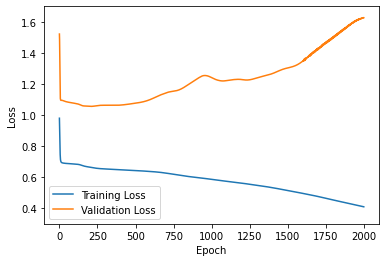

In [ ]:
window_size = 4
def make_model(window_size):
    model = Sequential()
    model.add(Dense(100, input_dim=window_size, kernel_initializer="uniform",
    activation="sigmoid"))
    model.add(Dropout(0.0))
    model.add(Dense(100, input_dim=window_size, kernel_initializer="uniform",
    activation="sigmoid"))
    model.add(Dropout(0.0))
    model.add(Dense(1, activation="linear")) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = make_model(window_size)
scaler = preprocessing.StandardScaler()
train = np.array(train).reshape(-1,1)

train_scaled = scaler.fit_transform(train) 

train_X,train_Y = [],[]
for i in range(0 , len(train_scaled) - window_size):
    train_X.append(train_scaled[i:i+window_size])
    train_Y.append(train_scaled[i+window_size])

new_train_X,new_train_Y = [],[]
for i in train_X:
    new_train_X.append(i.reshape(-1))
for i in train_Y:
    new_train_Y.append(i.reshape(-1))
new_train_X = np.array(new_train_X)
new_train_Y = np.array(new_train_Y)

fit = model.fit(new_train_X,new_train_Y, epochs=2000, batch_size=16, validation_split = .10, shuffle=False, verbose=1)

plt.plot(fit.history['loss'], label='Training Loss')
plt.plot(fit.history['val_loss'], label='Validation Loss')
plt.ylim([0.3,1.7])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



28/28 [==============================] - 0s 2ms/step


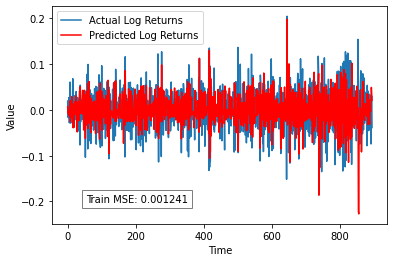

Train MSE: 0.001241


In [ ]:
predictions = model.predict(new_train_X)
predictions_rescaled=scaler.inverse_transform(predictions.reshape(-1, 1))
Y = pd.DataFrame(train[window_size:])
pred = pd.DataFrame(predictions_rescaled)
plt.plot(Y, label='Actual Log Returns')
plt.plot(pred , color = 'r', label='Predicted Log Returns')
plt.xlabel('Time')  
plt.ylabel('Value')  
plt.legend()
error = mse(train[window_size:],predictions_rescaled)
plt.text(0.1, 0.1, f'Train MSE: {error:.6f}', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
plt.show()
print('Train MSE: %.6f' % error)

4/4 [==============================] - 0s 2ms/step


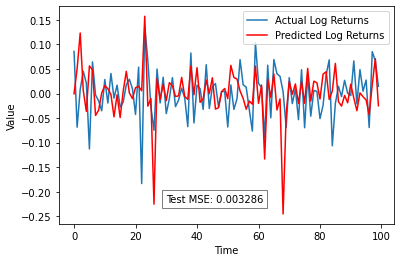

Test MSE: 0.003286


In [ ]:
test_extended = train.tolist()[-1*window_size:] + test
test_data = []
for i in test_extended:
    try:
        test_data.append(i[0])
    except:
        test_data.append(i)
test_data = np.array(test_data).reshape(-1,1)
test_scaled = scaler.transform(test_data)
test_X,test_Y = [],[]
for i in range(0 , len(test_scaled) - window_size):
    test_X.append(test_scaled[i:i+window_size])
    test_Y.append(test_scaled[i+window_size])
new_test_X,new_test_Y = [],[]
for i in test_X:
    new_test_X.append(i.reshape(-1))
for i in test_Y:
    new_test_Y.append(i.reshape(-1))
new_test_X = np.array(new_test_X)
new_test_Y = np.array(new_test_Y)


predictions = model.predict(new_test_X)
predictions_rescaled=scaler.inverse_transform(predictions)
predictions_rescaled = predictions_rescaled.flatten().tolist()

Y = pd.DataFrame(test)
pred = pd.DataFrame(predictions_rescaled)
plt.plot(Y, label='Actual Log Returns')
plt.plot(pred , color = 'r', label='Predicted Log Returns')
plt.xlabel('Time')  
plt.ylabel('Value')  
plt.legend()
error = mse(test,predictions_rescaled)
plt.text(0.32, 0.1, f'Test MSE: {error:.6f}', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
plt.show()
print('Test MSE: %.6f' % error)

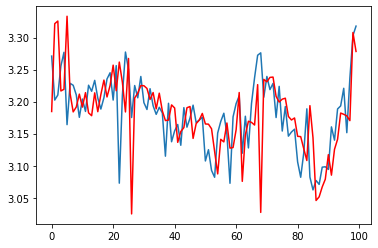

Test MSE: 0.003286


In [15]:
predicted_log_prices = np.zeros(len(logclose_test)) 
predicted_log_prices[0] = logclose_train[-1] + predictions_rescaled[0]

for t in range(1, len(logclose_test)):
    predicted_log_prices[t] = logclose_test[t-1] + predictions_rescaled[t] 


Y = pd.DataFrame(logclose_test)
pred = pd.DataFrame(predicted_log_prices)
plt.plot(Y)
plt.plot(pred , color = 'r')
plt.show()

error = mse(logclose_test,predicted_log_prices)
print('Test MSE: %.6f' % error)

In [16]:
import sys
sys.path.append('../Functions/Performance Metrics/')
from forecast_metrics import compute_error_metrics, compute_directional_metrics
print("Errors on logclose: ")
print(compute_error_metrics(logclose_test, predicted_log_prices))
print(compute_directional_metrics(logclose_test, predicted_log_prices))

Errors on logclose: 
{'NMSE': 1.0705425440516598, 'MAE': 0.04165665866047963, 'RMSE': 0.057322178236622695, 'MSE': 0.003285832117791141, 'MAPE': 1.310967958720719, 'TheilsU': 1.1266915907320412}
{'DA': 0.6464646464646465, 'DS': 0.47474747474747475, 'CU': 0.4909090909090909, 'CD': 0.45454545454545453}


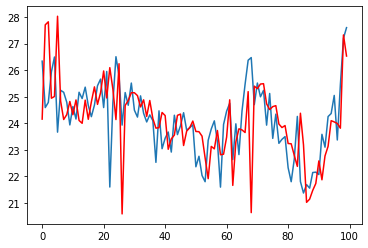

Test MSE: 1.899345


In [17]:
predicted_prices = np.exp(predicted_log_prices)
Y = pd.DataFrame(close_test)
pred = pd.DataFrame(predicted_prices)
plt.plot(Y)
plt.plot(pred , color = 'r')
plt.show()

error = mse(close_test,predicted_prices)
print('Test MSE: %.6f' % error)

In [18]:
import sys
sys.path.append('../Functions/Performance Metrics/')
from forecast_metrics import compute_error_metrics, compute_directional_metrics
print("Errors on close: ")
print(compute_error_metrics(close_test, predicted_prices))
print(compute_directional_metrics(close_test, predicted_prices))

Errors on close: 
{'NMSE': 1.073143409436852, 'MAE': 1.0012016209281105, 'RMSE': 1.378167356860979, 'MSE': 1.8993452635171766, 'MAPE': 4.168152744272768, 'TheilsU': 1.1037572834918348}
{'DA': 0.6464646464646465, 'DS': 0.47474747474747475, 'CU': 0.4909090909090909, 'CD': 0.45454545454545453}


Stock: 26.339 Action: Buy Portfolio: 26339.0 Stocks: 1000 Balance_init: 0 total($) 26339.0
Stock: 24.591 Action: Bought--Holding Portfolio: 24591.0 Stocks: 1000 Balance_init: 0 total($) 24591.0
Stock: 24.786 Action: Bought--Holding Portfolio: 24786.0 Stocks: 1000 Balance_init: 0 total($) 24786.0
Stock: 25.934 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25934.0
Stock: 26.495 Action: Buy Portfolio: 25912.11 Stocks: 978 Balance_init: 21 total($) 25933.11
Stock: 23.666 Action: Bought--Holding Portfolio: 23145.35 Stocks: 978 Balance_init: 21 total($) 23166.35
Stock: 25.243 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 24708.65
Stock: 25.166 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 24708.65
Stock: 24.793 Action: Buy Portfolio: 24693.83 Stocks: 996 Balance_init: 14 total($) 24707.83
Stock: 23.938 Action: Bought--Holding Portfolio: 23842.25 Stocks: 996 Balance_init: 14 total($) 23856.25
Stock: 24.631 Action: Bought--

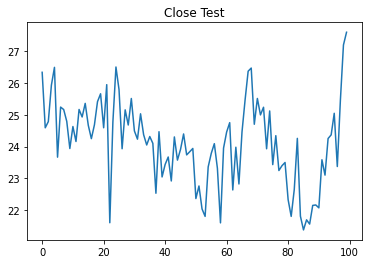

Final value of stock:
27.601


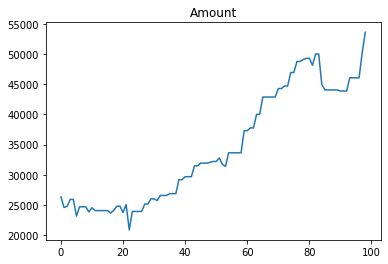

Final value of portfolio:
53605.0


In [ ]:
import sys
sys.path.append('../Functions/Performance Metrics/')
from trading_strategies import trading_strategy1

trading_strategy1(close_test, predicted_prices)
            
